In [1]:
import itertools
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import networkx as nx
import networkx.algorithms.community as nxcom
from node2vec import Node2Vec

G:\Anacoda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [86]:
df = pd.read_excel('../data/all_submission_files2.xlsx')
data=df[df["report_end_date"].dt.year==2020]
info = pd.read_excel('../data/investees_info.xlsx')
info = info.set_index('ticker')

In [87]:
#join dataframe df and info together based on the column "ticker"
test = df.join(info, on="ticker")
test.head(10)

,Unnamed: 0,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType,ticker,...,address2,fax,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid,err,address3,averageMaturity,year_of_foundation
0,0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH,SHW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1866.0
1,1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH,DIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH,IWB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH,QQQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH,IWM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH,SPY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2020-09-30,1129770,Amazon Com Inc,COM,23135106,1032783000,328,SH,AMZN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.0
7,7,2020-09-30,1129770,SPDR S&P Homebuild,COM,78464a888,879628000,16326,SH,SPY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2020-09-30,1129770,Central Fd Cda Ltd,COM,153501101,783173000,42703,SH,9999750D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2020-09-30,1129770,Accelerate Diagnos,COM,00430h105,690395000,64765,SH,AXDX,...,Suite 470 4th Floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1982.0


In [88]:
# Find all the possible CIK combinations (sorted) of length 2
all_cik_pairs = list(itertools.combinations(test['cik'].unique(), 2))

In [89]:
def Amount_of_shared_age(L1,L2):
    L1 = L1.dropna()
    L1n = len(L1)
    L2 = L2.dropna()
    L2n = len(L2)
    shared_age = 0
    for year_of_foundation in L1:
        if year_of_foundation in L2.values:
            loc = L2[L2 == year_of_foundation].index[0]
            L2 = L2.drop(index=loc)
            shared_age = shared_age + 1
    if(L1n+L2n == 0):
        return 0
    else:
        return shared_age*2/(L1n+L2n)

In [92]:
nodes_and_edges = []
for cik_pair in all_cik_pairs:
    df1 = test[test['cik']==cik_pair[0]]
    df2 = test[test['cik']==cik_pair[1]]
    nb_of_shared_age = Amount_of_shared_age(df1["year_of_foundation"], df2["year_of_foundation"])
    nodes_and_edges.append([cik_pair, nb_of_shared_age])

In [114]:
# Build a network of all CIK's.
# Add an edge between each CIK that invests in overlapping cusips, add weight +1 for each overlapping cusip
G=nx.Graph()
for (cik1, cik2), nb_of_shared_age in nodes_and_edges:
    if nb_of_shared_age == 0:
        pass
        # Don't add the nodes that are not connected, makes the graph impossible to understand
        # G.add_node(cik1)
        # G.add_node(cik2)
    elif nb_of_shared_age > 0.65:
        # Take a mimimum amount of shared cusips for visibility
        G.add_edge(cik1,cik2,weight=nb_of_shared_age)

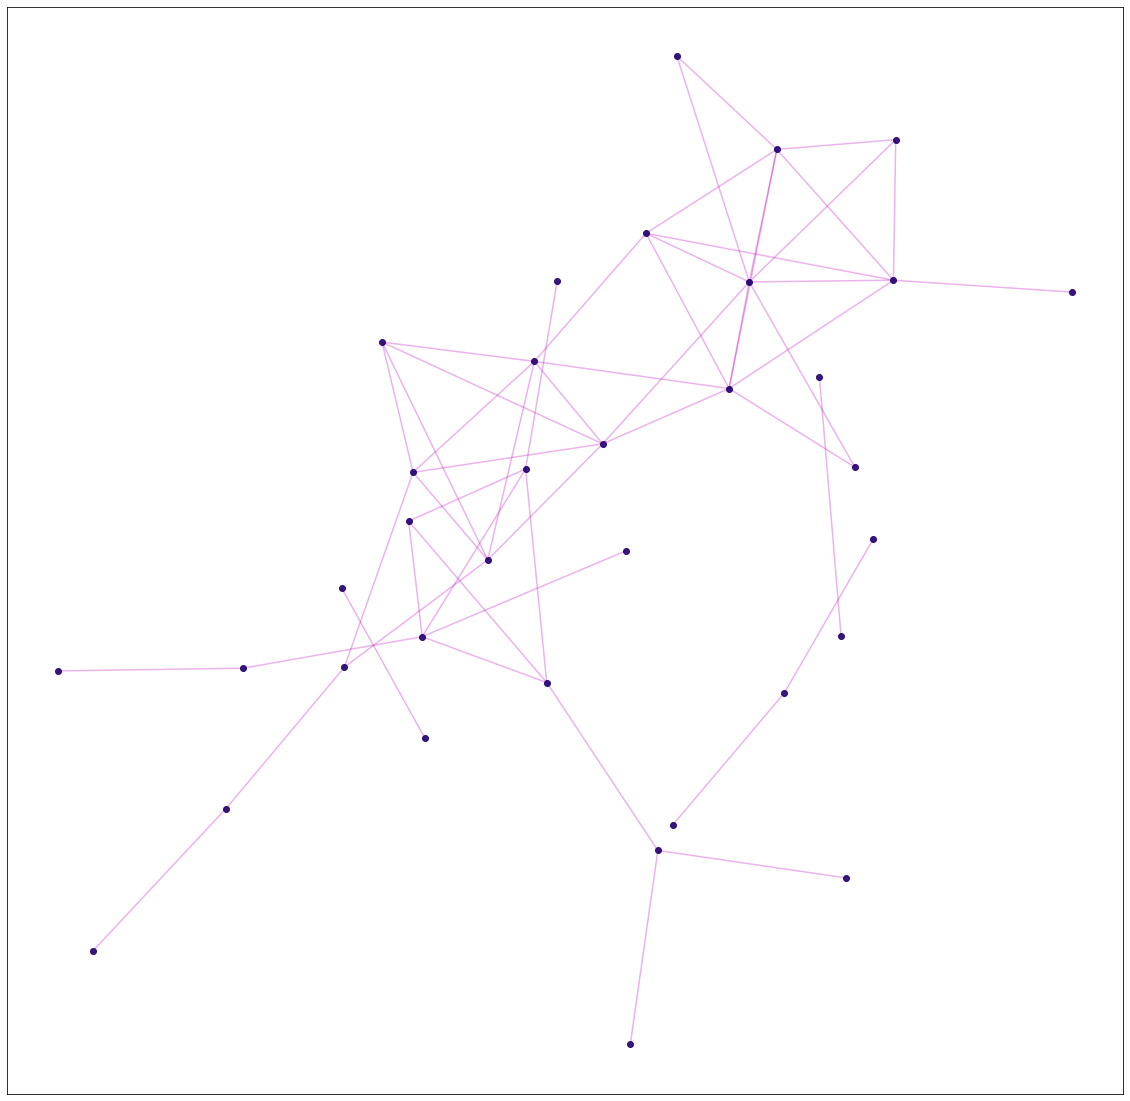

In [115]:
G.edges(data=True)
node_size =  None
edge_width = [w for _,w in nodes_and_edges]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,20))
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, width=None, edge_color="m")
nx.draw_networkx_nodes(G, pos, node_size=None, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
# _ = nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

In [116]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The group of investment funds has {len(communities)} communities.")

The group of investment funds has 8 communities.


In [117]:
# Helper functions to plot the graph with community labels
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [118]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

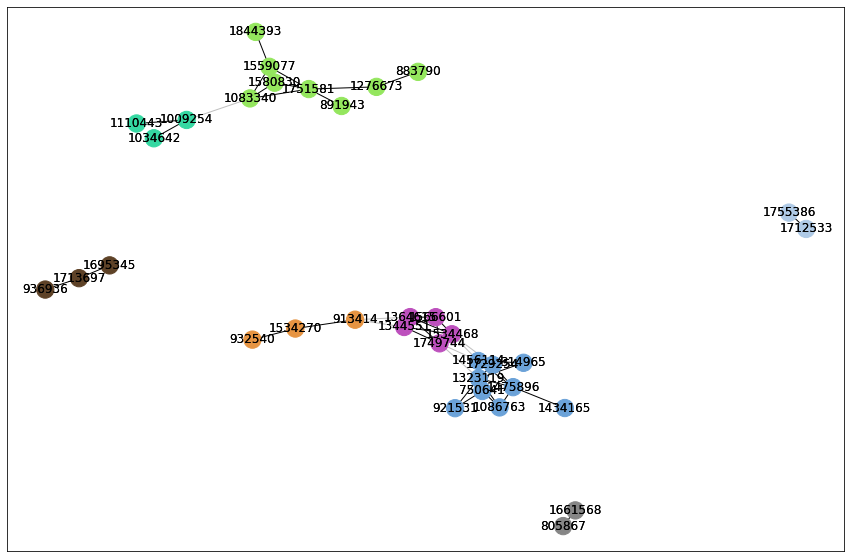

In [119]:
comm_pos = nx.spring_layout(G)

plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)